In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tools.data_utils import PinDataset, ToTensor, Resize
from PIL import Image

/home/ozcan.g/.conda/envs/satellite_gpu_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_folder = f"./data/Synthetic/28by28pixels_10images_123456seed"
d1 = 28
d2 = 28
pin_folder = f"{data_folder}/mesh_10step_pins"
image_folder = f"{data_folder}/images/"

In [3]:
pins_file = f"{pin_folder}/pins.csv"
pins_df = pd.read_csv(pins_file)
pins_df

,image,pins,outputs
0,0.png,"[(10, 10), (0, 20), (20, 10), (20, 0), (0, 10)...","[6.098613533844307, 2.3027954428213175, -6.881..."
1,1.png,"[(0, 20), (20, 0), (10, 10), (10, 0), (0, 0), ...","[-2.1219218622971954, 10.23563779697513, 4.597..."
2,2.png,"[(10, 0), (0, 20), (0, 10), (20, 0), (10, 20),...","[7.767955712981963, 2.6261241699093545, -3.520..."
3,3.png,"[(20, 20), (20, 10), (0, 20), (0, 0), (10, 10)...","[3.336112098347699, -6.337185272706277, 0.5354..."
4,4.png,"[(0, 0), (10, 10), (20, 0), (20, 20), (10, 20)...","[9.051104146636956, 5.516287328155483, 9.05007..."
5,5.png,"[(10, 0), (0, 0), (20, 10), (0, 10), (10, 10),...","[9.803678880955262, 9.803554232899053, -8.1780..."
6,6.png,"[(20, 20), (0, 20), (10, 20), (0, 0), (0, 10),...","[4.313570195687096, 1.5123190268209705, 3.5649..."
7,7.png,"[(20, 10), (0, 10), (10, 20), (0, 0), (20, 0),...","[-7.41874300232275, -3.718950838979743, 1.0635..."
8,8.png,"[(20, 10), (10, 0), (20, 0), (10, 20), (20, 20...","[-5.823787267350181, 10.064181179225708, 10.06..."
9,9.png,"[(10, 10), (0, 20), (10, 20), (20, 10), (20, 2...","[2.9751365856200187, -1.1840308288681842, 0.86..."


In [4]:
# y_file = f"{data_folder}/y.csv"
# out_df = pd.read_csv(y_file)
# out_df

In [5]:
img_name = pins_df.iloc[0, 0]
pins = eval(pins_df.iloc[0, 1])
pins = np.asarray(pins)
pins

array([[10, 10],
       [ 0, 20],
       [20, 10],
       [20,  0],
       [ 0, 10],
       [10, 20],
       [20, 20],
       [10,  0],
       [ 0,  0]])

In [6]:
outputs = eval(pins_df.iloc[0, 2])
outputs = np.asarray(outputs)
outputs

array([ 6.09861353,  2.30279544, -6.88135258,  9.80330666, -3.18161867,
        4.35518523,  5.10318583,  9.80330661,  9.80330659])

In [7]:
io.imread(f"{data_folder}/images/{img_name}").shape

(539, 539, 4)

In [14]:
def show_pins(image, pins, outputs):
    """Show image with pins"""
    plt.imshow(image.permute(1, 2, 0), extent=[0,d1,0,d2])
    plt.scatter(pins[:, 0], pins[:, 1], s=10, marker='.', c='r')
    # plt.pause(0.001)  # pause a bit so that plots are updated
    # there is a shift in the pins probably

# plt.figure()
# # show_pins(io.imread(f"{data_folder}/images/{img_name}"), pins, outputs)
# show_pins(np.load(f"{data_folder}/images/{img_name}"), pins, outputs)
# plt.show()

0 torch.Size([4, 28, 28]) torch.Size([9, 2])
1 torch.Size([4, 28, 28]) torch.Size([9, 2])
2 torch.Size([4, 28, 28]) torch.Size([9, 2])
3 torch.Size([4, 28, 28]) torch.Size([9, 2])


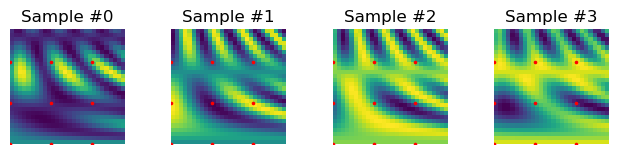

In [16]:
transform = transforms.Compose([
    ToTensor(),  # Convert to tensor (as you were doing)
    Resize()  # Resize to 100x100
])

heatmap_dataset = PinDataset(csv_file=f"{pin_folder}/pins.csv",
                                 root_dir=image_folder,
                                 transform=transform)

# heatmap_dataset = SynthHeatmapDataset(csv_file=f"{data_folder}/pins.csv",
#                                       root_dir=f"{data_folder}/images/")

fig = plt.figure()

for i, sample in enumerate(heatmap_dataset):
    print(i, sample['image'].shape, sample['pins'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    # image = sample['image']
    # image = image.view(image.shape[1], image.shape[2], image.shape[0])
    # show_pins(image, sample['pins'], sample['outputs'])
    show_pins(**sample)
    
    if i == 3:
        plt.show()
        break

In [11]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, pins, outputs = sample['image'], sample['pins'], sample['outputs']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'pins': torch.from_numpy(pins),
                'outputs': torch.from_numpy(outputs)}

In [18]:
transformed_dataset = PinDataset(csv_file=f"{pin_folder}/pins.csv",
                                          root_dir=image_folder,
                                          transform=transforms.Compose([ToTensor(), Resize()])
                                         )

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['pins'].size(), sample['outputs'].size())

    if i == 3:
        break

0 torch.Size([4, 28, 28]) torch.Size([9, 2]) torch.Size([9])
1 torch.Size([4, 28, 28]) torch.Size([9, 2]) torch.Size([9])
2 torch.Size([4, 28, 28]) torch.Size([9, 2]) torch.Size([9])
3 torch.Size([4, 28, 28]) torch.Size([9, 2]) torch.Size([9])
